In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import optimize
import numpy as np
from scipy.interpolate import UnivariateSpline
import pylab as pl
from matplotlib.lines import Line2D
import os
import sys

In [2]:
def get_file_paths(root_dir: str, file_format: str = '.csv', exclude_hidden: str = True):
    '''Crawles over directory (including sub-directories) and returns list of file paths matching file format. 

    Positional arguments:
        - root_dir: str -- Path of root directory to be crawled over
    
    Keyword arguments:
        - file_format: str -- e.g. .csv (default), .xls, ...

    Returns:
        - list -- Paths for files meeting file_format requirement.
    '''
    file_paths = []

    for root, _, files in os.walk(root_dir):
        for path in files:
            if exclude_hidden and path.startswith('.'):
                continue
            if file_format in path:
                file_paths.append(os.path.join(root, path))

    return file_paths

def select_occurences_from_list(list_of_objects, occurence):
    ''' Rounds value up to order of precision. 

        Positional Arguments:
            - list: List -- List of items
            - occurence: Union[int, str, float] -- Item to be removed from the list

        Returns:
            - List[Any] -- List without occurence(s)
    '''

    list_without_occurence = [item for item in list_of_objects if occurence in item]
    return list_without_occurence


def filter_dataframe(dataframe, column_name: str, filter_operator: str, value):
    '''Filters pandas dataframe by a query. The query is composed of a column, a filter operator
    and a corresponding value. Possible filter operators are:

        - '==' : EQUALS
        - '<=' : LESS EQUALS
        - '>=' : GREATER EQUALS
        - '!=' : NOT EQUALS
        - '>' : GREATER
        - '<' : LESS

    Positional arguments:
        column_name: str -- Column to which the filter is applied
        filter_operator: str -- String of filter operator
        value: Union[int, float, str] -- Value
        
    Returns:
        DataFrame -- Dataframe filtered by query
    '''
    if type(value) == str:
        query_str   = f'{column_name}{filter_operator}"{value}"'
    else:
        query_str   = f'{column_name}{filter_operator}{value}'

    filtered_df = dataframe.query(query_str)
    return filtered_df

In [3]:
# gaussian fit
def gauss(x, mu, sigma, A):
    return A /(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# fwhm
def fwhm(x, y):
    half = max(y) / 2
    left = []
    for i in range(len(y)):
        if y[i] - half > 0:
            left.append(i)
    return x[left[0]], x[left[-1]], x[left[-1]] - x[left[0]]

# flat top gaussian
def cut_gauss(x, mean, sd, A, cutoff):
    gx = A /(sd * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / sd)**2)
    result = []
    for i in range(len(gx)):
        g = min(gx[i], cutoff)
        result.append(g)
    return result

In [4]:
data_dir=r"C:\Users\Josephine van Driel\Documents\SHIPTRAP\Measurements\frequency_scan\FHWM\\" # this needs to be changed to wherever the frequency scans are stored

list_of_file_paths=get_file_paths(root_dir=data_dir, file_format=".txt")
list_of_file_paths_mbar = select_occurences_from_list(list_of_file_paths, "mbar")

dataframes = []
for path in list_of_file_paths_mbar:
    current_df = pd.read_csv(path, names = ['frequency', 'count', 'error'], delimiter = ' ')
    split_file_path = path.split("_")
    file_name_pressure = split_file_path[-1]
    file_name_time = split_file_path[-6]
    file_name_voltage = split_file_path[-5]
    
    time1 = file_name_time.split("\\")[-1]
    time = time1.split("ms")[0]
    voltage = file_name_voltage.split("V")[0]
    pressure = file_name_pressure.split("mbar")[0]
    
    current_df["gas_flow_mbar_l_per_s"] = pressure
    current_df["voltage_V"] = voltage
    current_df["time_ms"] = time
    dataframes.append(current_df)
complete_df = pd.concat(dataframes)
complete_df = complete_df.apply(pd.to_numeric)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

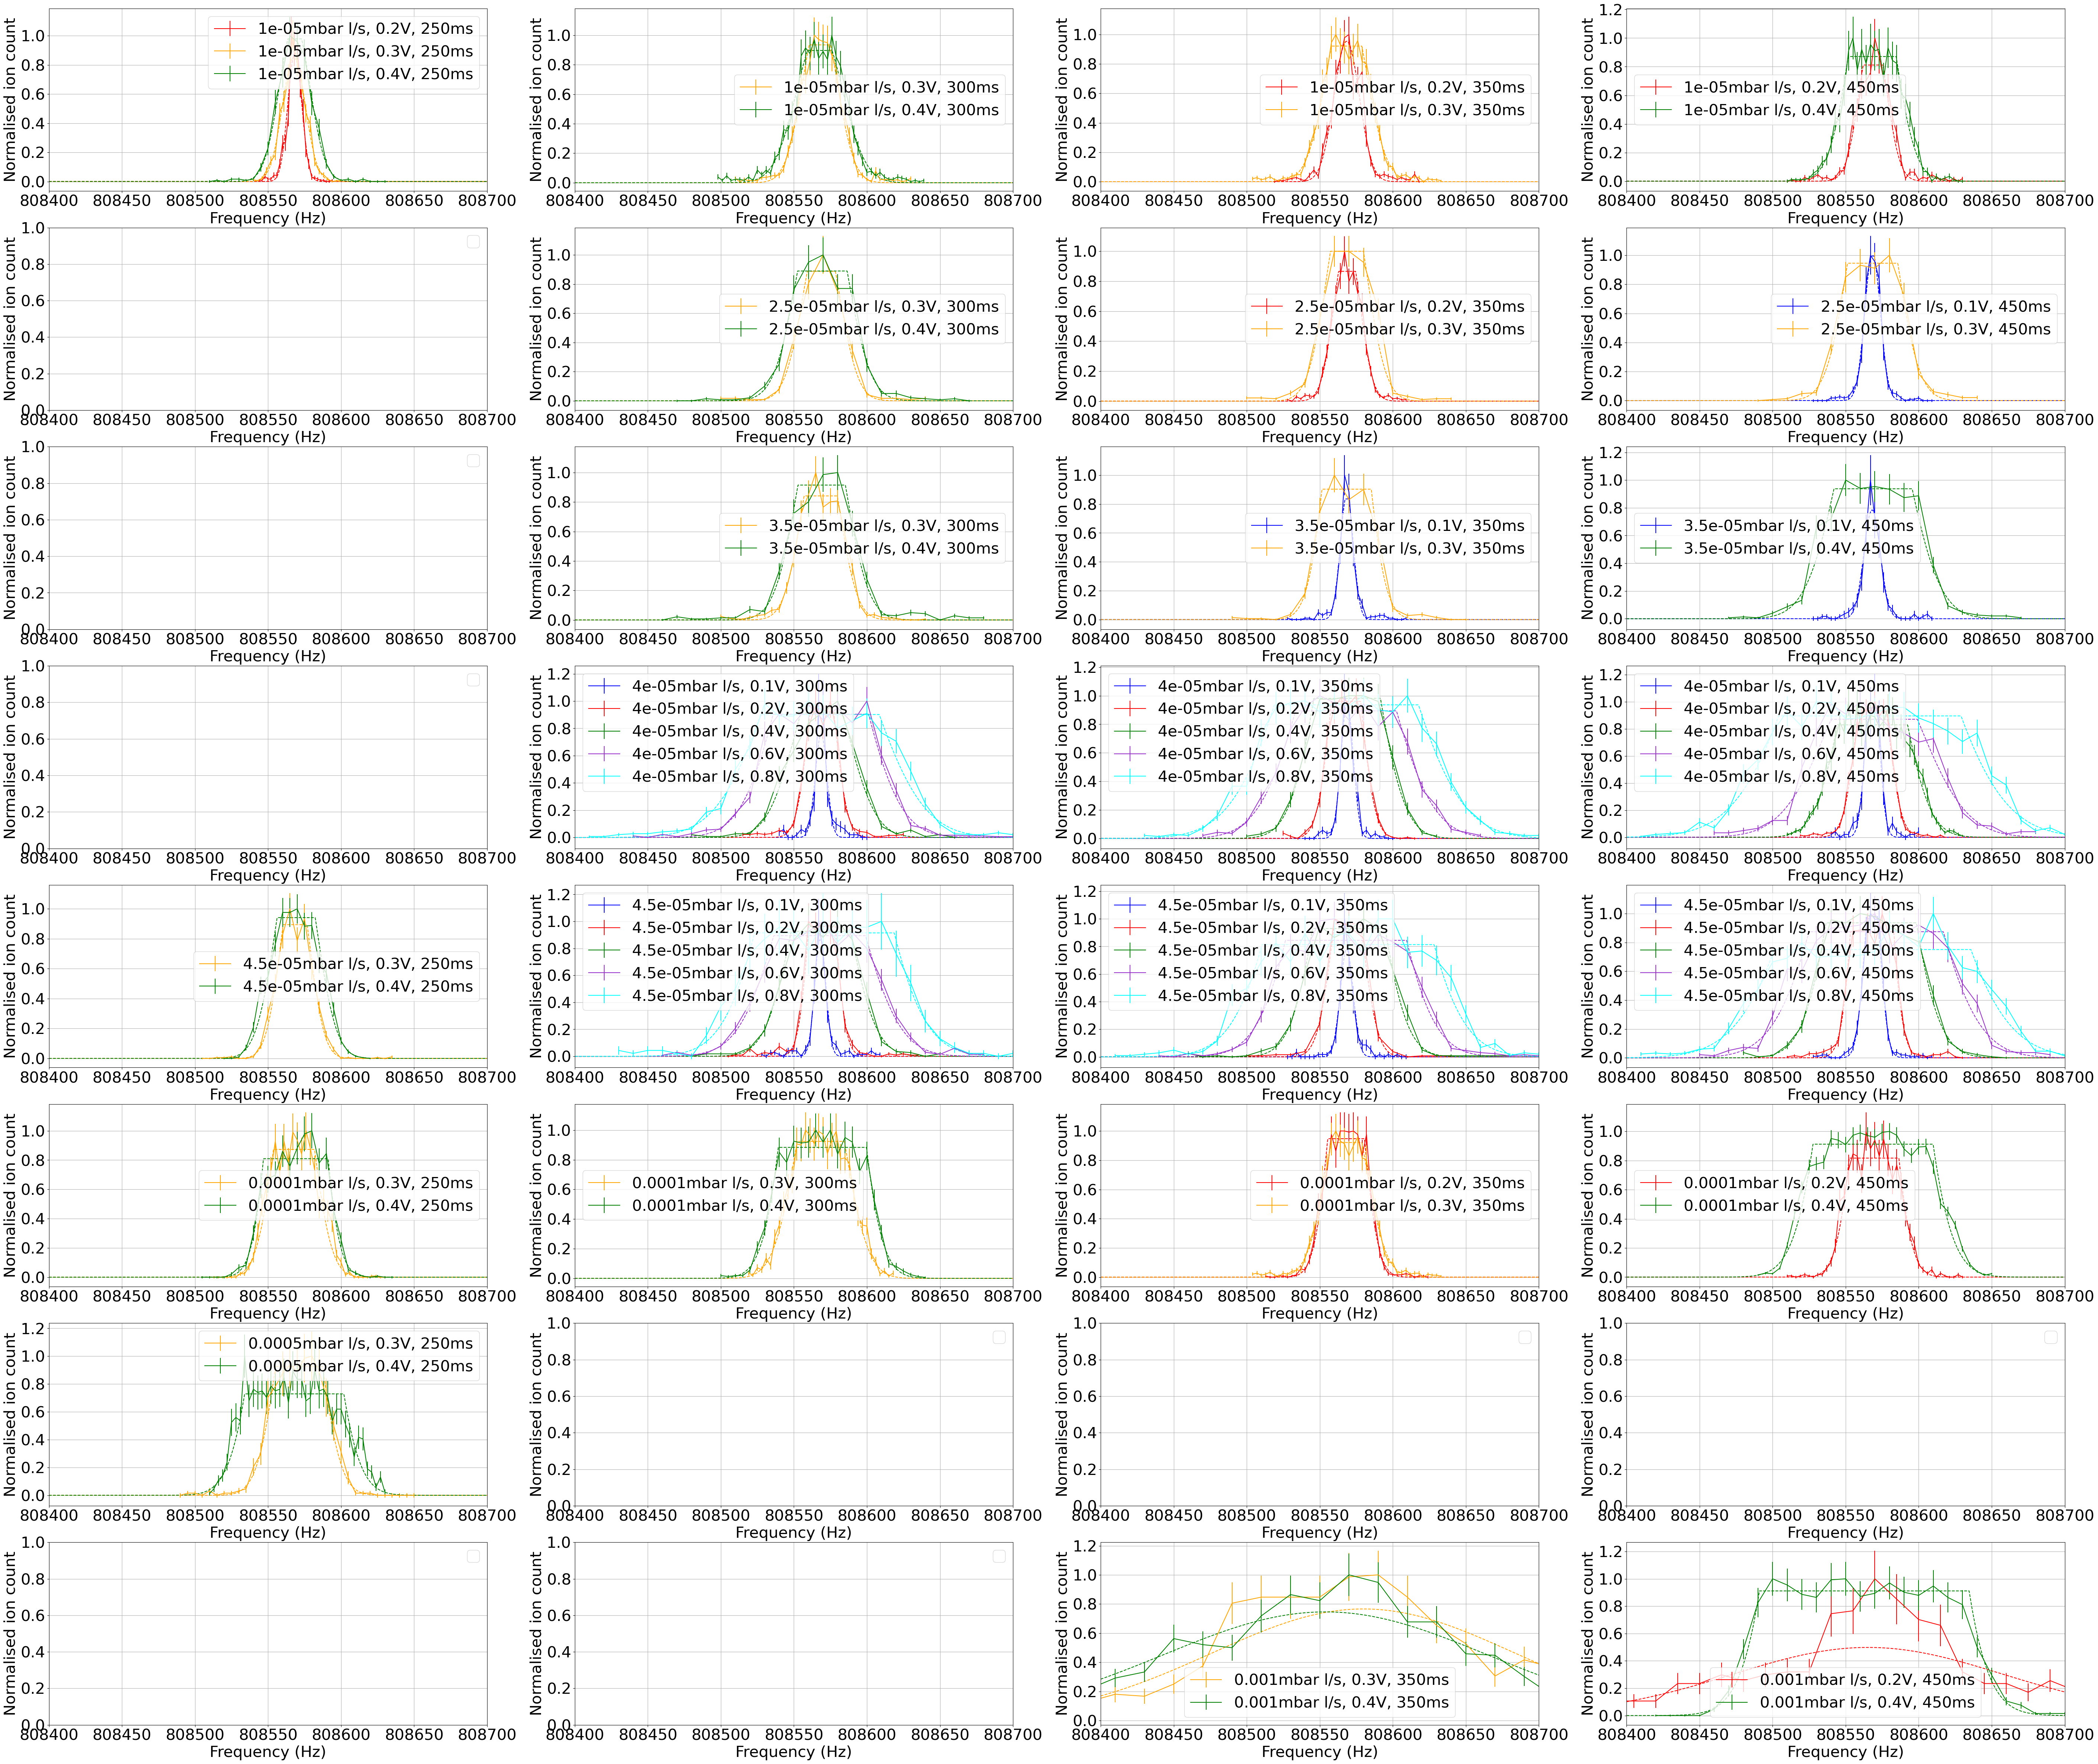

In [5]:
function = cut_gauss   # choose fitting function
inParams = [808570, 5, 5, 0.8] # initial guess params to fit against

x = np.linspace(808400, 808700, 1000)     # for plotting the curve fitting
colors = ['blue', 'red', 'orange', 'green', 'darkorchid', 'cyan']   # color for each voltage
popt, pcov, optx, optn, perr, params1, v = [], [], [], [], [], [], []

voltageaxis = complete_df["voltage_V"].unique()
timeaxis = complete_df["time_ms"].unique()
gasflowaxis = complete_df["gas_flow_mbar_l_per_s"].unique()
# print(gasflowaxis)
# gasflowaxis = np.delete(gasflowaxis, [1, 4, 5])
gasflowaxis = np.sort(gasflowaxis)
timeaxis = np.sort(timeaxis)
voltageaxis = np.sort(voltageaxis)
# print(gasflowaxis)
fig, ax = plt.subplots(len(gasflowaxis), len(timeaxis), figsize = (70, 60))

for i in range(len(timeaxis)):
    df_time = filter_dataframe(complete_df, "time_ms", "==", timeaxis[i])
    for j in range(len(gasflowaxis)):
        plt.sca(ax[j][i])
        plt.xlabel("Frequency (Hz)", fontsize = 30)
        plt.ylabel("Normalised ion count", fontsize = 30)
        df_gas = filter_dataframe(df_time, "gas_flow_mbar_l_per_s", "==", gasflowaxis[j])
        v_a, params, opt1, cov1, opt1max, opt1min, perr1 = [], [], [], [], [], [], []
        for k in range(len(voltageaxis)):#voltage in voltageaxis:
            df_v = filter_dataframe(df_gas, "voltage_V", "==", voltageaxis[k])
            params.append([gasflowaxis[j], voltageaxis[k], timeaxis[i]])
            if df_v.empty == True:
                continue
            else:
                err = (df_v["count"] / max(df_v["count"])) * np.sqrt(1 / df_v["count"] +
                                                                             1 / max(df_v["count"]))
                err = np.nan_to_num(err, copy = False, nan = 1 /  max(df_v["count"]))
                
                plt.errorbar(df_v["frequency"], df_v["count"] / max(df_v["count"]), yerr = err,
                             label = f"{gasflowaxis[j]}mbar l/s, {voltageaxis[k]}V, {timeaxis[i]}ms", color = colors[k])
                opt, cov = optimize.curve_fit(function, df_v["frequency"], df_v["count"] / max(df_v["count"]),
                                              sigma = err, p0 = inParams, method = 'dogbox')
                plt.plot(x, function(x, *opt), "--", color = colors[k])
                opt1.append(opt)
                cov1.append(cov)
                
                v_a.append(voltageaxis[k])
                per = np.sqrt(np.diag(cov))
                optmax = opt + per
                optmin = opt - per
                opt1max.append(optmax)
                opt1min.append(optmin)
                perr1.append(per)
        popt.append(opt1)
        pcov.append(cov1)
        perr.append(perr1)
        optx.append(opt1max)
        optn.append(opt1min)
        params1.append(params)
        v.append(v_a)
        plt.grid()
        plt.xlim(808400, 808700)
        plt.legend(fontsize = 30)
        plt.xticks(fontsize = 30)
        plt.yticks(fontsize = 30)
plt.show()

[1.0e-05 2.5e-05 3.5e-05 4.0e-05 4.5e-05 1.0e-04 5.0e-04 1.0e-03]
    voltage         res_p    res_p_err  gas_flow  cyc_cool_time  \
39      0.2  32053.976502  1144.784875  0.000010          450.0   
40      0.4  17041.342329  1078.565970  0.000010          450.0   
41      0.1  64107.923759  7631.895686  0.000025          450.0   
42      0.3  16220.079067  1563.381115  0.000025          450.0   
43      0.1  62617.019648  7281.048796  0.000035          450.0   
44      0.4  10770.136086  1120.094153  0.000035          450.0   
45      0.1  65671.518736  4805.233079  0.000040          450.0   
46      0.2  27474.820588  1682.131873  0.000040          450.0   
47      0.4  12351.067580   566.562733  0.000040          450.0   
48      0.1  56094.419225     0.019863  0.000045          450.0   
49      0.2  22069.933461  4341.626255  0.000045          450.0   
50      0.4  10084.380933   830.922774  0.000045          450.0   
51      0.2  18192.812699  1352.168511  0.000100          450.0

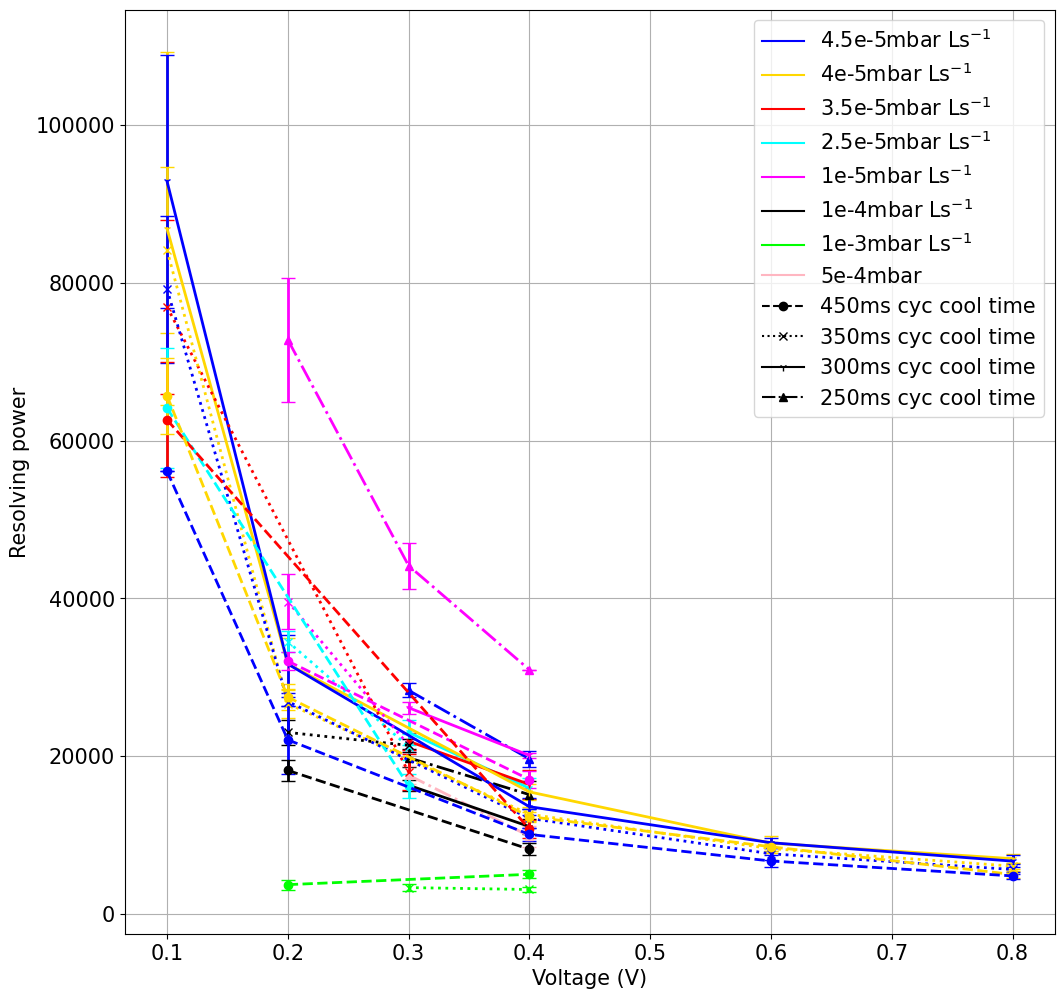

In [6]:
fig1, ax1 = plt.subplots(1, 1, figsize = (12, 12))

vc, FWHM, yer, res_p, measurements = [], [], [], [], []
for i in range(len(popt)):
    vc_a, fwhm_a, er_a, rp = [], [], [], []
    for j in range(len(popt[i])):
        left, right, width = fwhm(x, function(x, *popt[i][j]))
        widthx = fwhm(x, function(x, *optx[i][j]))
        widthn = fwhm(x, function(x, *optn[i][j]))
        err = popt[i][j][0] / width * np.sqrt((((optx[i][j][0] - optn[i][j][0]) / 2)
                                                    / popt[i][j][0])**2 + ((widthx[2] - widthn[2])/ width)**2)
        vc_a.append([popt[i][j][0], width])
        fwhm_a.append(width)
        rp.append(popt[i][j][0] / width)
        er_a.append(err)
    FWHM.append(fwhm_a)
    vc.append(vc_a)
    yer.append(er_a)
    res_p.append(rp)
print(gasflowaxis)
for i in range(len(res_p)):
    if params1[i][0][0] == 4.5e-05:
        c = "blue"
    if params1[i][0][0] == 4e-05:
        c = "gold"
#         continue
    if params1[i][0][0] == 3.5e-05:
        c = "red"
#         continue
    if params1[i][0][0] == 2.5e-05:
        c = "cyan"
#         print(res_p[i])
#         continue
    if params1[i][0][0] == 1e-05:
        c = "fuchsia"
    if params1[i][0][0] == 1e-04:
        c = "black"
    if params1[i][0][0] == 1e-03:
        c = "lime"
    if params1[i][0][0] == 5e-04:
        c = "lightpink"
    if params1[i][0][2] == 450:
        style = "--o"
    if params1[i][0][2] == 350:
        style = ":x"
    if params1[i][0][2] == 300:
        style = "-1"
    if params1[i][0][2] == 250:
        style = "-.^"
    plt.errorbar(v[i], res_p[i], fmt = style, yerr = yer[i],
                 label = f"{params1[i][0][0]}mbar L s$^-1$, {params1[i][0][2]}ms",
                 capsize = 5, color = c, alpha = 1, linewidth = 2)
    for k in range(len(res_p[i])):
        if v[i][k] < 0.6:
            measurements.append([v[i][k], res_p[i][k], yer[i][k], params1[i][0][0], 
                             params1[i][0][2], vc[i][k][0], vc[i][k][1]])
# print(params1)
measurements = np.vstack(measurements)
measurements = pd.DataFrame(measurements, columns = ["voltage", "res_p", "res_p_err", "gas_flow",
                                                     "cyc_cool_time", "opt_vc", "opt_fwhm"])
custom_lines = [Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="gold"),
                Line2D([0], [0], color="red"), 
                Line2D([0], [0], color="cyan"),
                Line2D([0], [0], color="fuchsia"),
                Line2D([0], [0], color="black"),
                Line2D([0], [0], color="lime"), 
                Line2D([0], [0], color="lightpink"), 
                Line2D([0], [0], marker='o', linestyle = "--", color = "black"),
                Line2D([0], [0], marker='x', linestyle = ":", color = "black"), 
                Line2D([0], [0], marker='1', linestyle = "-", color = "black"),
                Line2D([0], [0], marker='^', linestyle = "-.", color = "black")]
#                 Line2D([0], [0], fmt = ':p', color = "black")
#                 Line2D([0], [0], fmt = '-x', color = "black")
#                 Line2D([0], [0], fmt ='-.', color = "black")]

ax1.legend(custom_lines, ["4.5e-5mbar Ls$^{-1}$", "4e-5mbar Ls$^{-1}$", "3.5e-5mbar Ls$^{-1}$", 
                          "2.5e-5mbar Ls$^{-1}$", "1e-5mbar Ls$^{-1}$", "1e-4mbar Ls$^{-1}$", 
                          "1e-3mbar Ls$^{-1}$", "5e-4mbar",
                          "450ms cyc cool time", "350ms cyc cool time",
                          "300ms cyc cool time", "250ms cyc cool time", 
                          ""],
           fontsize = 15)
plt.grid()
plt.ylabel("Resolving power", fontsize = 15)
plt.xlabel("Voltage (V)", fontsize = 15)
# plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# print(measurements)
print(filter_dataframe(measurements, "cyc_cool_time", "==", 450))
plt.show()

In [7]:
df = pd.read_csv(r"C:\Users\Josephine van Driel\Documents\SHIPTRAP\133cs_PT_frequency_scan.csv")
# print(df)
# print(len(df))
for i in range(len(df)):
    if float(df["voltage_V"][i]) >= 0.6:
        df = df.drop([i])
        
# print(df["voltage_V"])
# print(len(df))
# print(len(measurements))

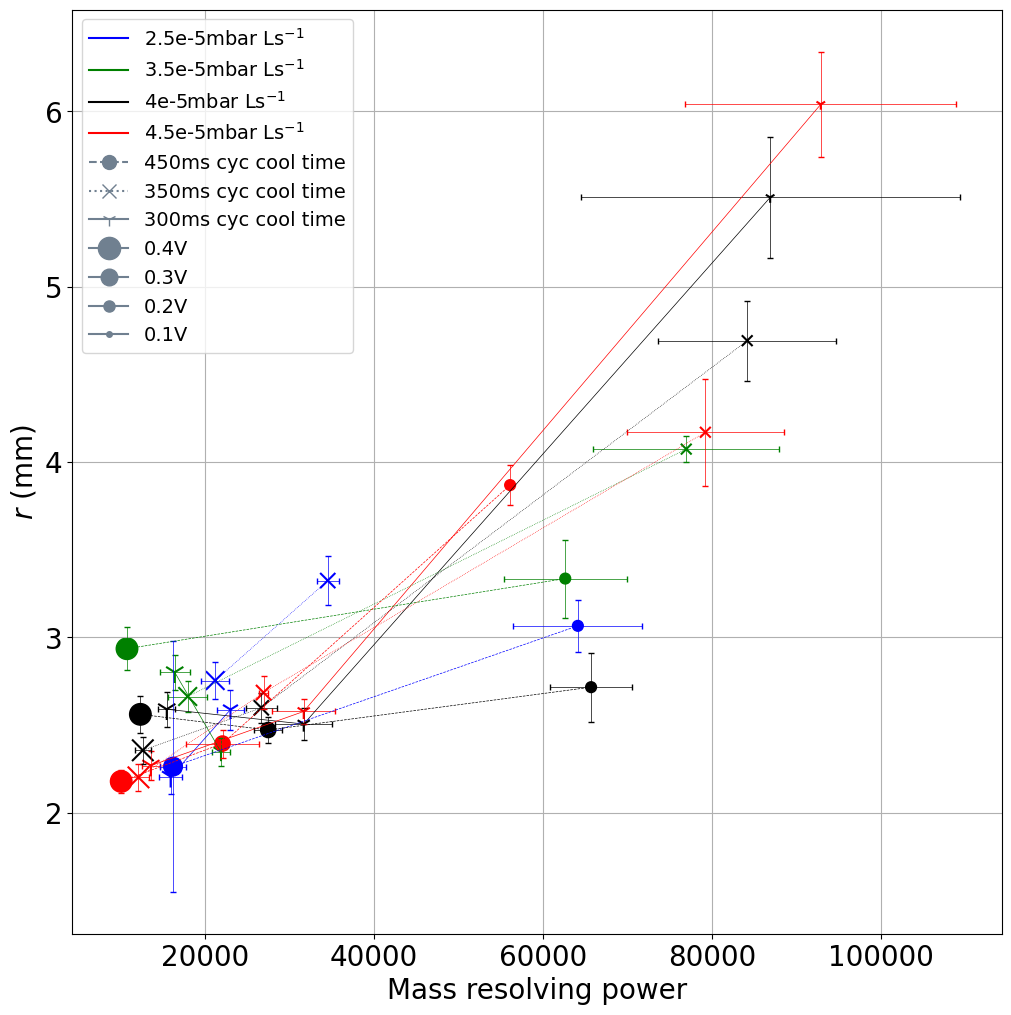

In [18]:
times = np.sort(measurements["cyc_cool_time"].unique())
gases = np.sort(measurements["gas_flow"].unique())
volts = np.sort(measurements["voltage"].unique())
fig2, ax2 = plt.subplots(1, 1, figsize = (12, 12))
for t in times:
    mtime = filter_dataframe(measurements, "cyc_cool_time", "==", t)
    dftime = filter_dataframe(df, "cyc_cooling_time", "==", t)
    for g in gases:
            mvolt = filter_dataframe(mtime, "gas_flow", "==", g)
            dfvolt = filter_dataframe(dftime, "gas_flow", "==", g)
            if mvolt.empty == True:
                continue
            if g == 1e-5:
                continue
#                 c = "red"
            if g == 2.5e-5:
                c = "blue"
#                 continue
            if g == 3.5e-5:
                c = "green"
#                 continue
            if g == 4e-5:
                c = "black"
#                 continue
            if g == 4.5e-5:
#                 continue
                c = "red"
            if g == 1e-4:
                continue
#                 c = "magenta"
            if g == 1e-3:
                continue
                c = "orange"
            if g == 5e-4:
                continue
                c = "yellow"
            if t == 450:
                style = "--o"
                style1 = "o"
            if t == 350:
                style = ":x"
                style1 = "x"
            if t == 300:
                style = "-1"
                style1 = "1"
#             if t != 450:
#                 continue
            if t == 250:
                continue
#                 style = "-^"
            sizes = [float(mvolt["voltage"].unique()[i] * 600) for i in range(len(mvolt["voltage"].unique()))]
#             print(sizes )
            plt.errorbar(x = mvolt["res_p"], y = dfvolt["eff_radius"], 
                         xerr = mvolt["res_p_err"], yerr = dfvolt["total_err"],
                         color = c, fmt = style, capsize = 2, linewidth = 0.5, markersize = 0.1)
            plt.scatter(x = mvolt["res_p"], y = dfvolt["eff_radius"],
                         color = c, marker = style1, s = sizes)
            
plt.grid()
plt.xlabel("Mass resolving power", fontsize = 20)
plt.ylabel("$r$ (mm)", fontsize = 20)
custom_lines = [
#                 Line2D([0], [0], color="red"),
                Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="green"), 
                Line2D([0], [0], color="black"),
                Line2D([0], [0], color="red"),
#                 Line2D([0], [0], color="magenta"),
#                 Line2D([0], [0], color="orange"), 
#                 Line2D([0], [0], color="yellow"), 

                Line2D([0], [0], marker='o', linestyle = "--", color = "slategray", markersize = 10),
                Line2D([0], [0], marker='x', linestyle = ":", color = "slategray", markersize = 10), 
                Line2D([0], [0], marker='1', linestyle = "-", color = "slategray", markersize = 10),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 16),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 12),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 8),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 4)]

ax2.legend(custom_lines, [
#                           "1e-5mbar Ls$^{-1}$",
                          "2.5e-5mbar Ls$^{-1}$",
                          "3.5e-5mbar Ls$^{-1}$", 
                          "4e-5mbar Ls$^{-1}$",
                          "4.5e-5mbar Ls$^{-1}$",
#                           "1e-4mbar Ls$^{-1}$",
#                           "1e-3mbar Ls$^{-1}$", 
#                           "5e-4mbar Ls$^{-1}$",
                          "450ms cyc cool time",
                          "350ms cyc cool time",
                          "300ms cyc cool time",
                           "0.4V", "0.3V", "0.2V", "0.1V"],
#                           "250ms cyc cool time"],
                        fontsize = 14)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
# print()
plt.show()    

[60.0, 120.0, 240.0]
[60.0, 120.0, 240.0]
[60.0, 120.0, 240.0]


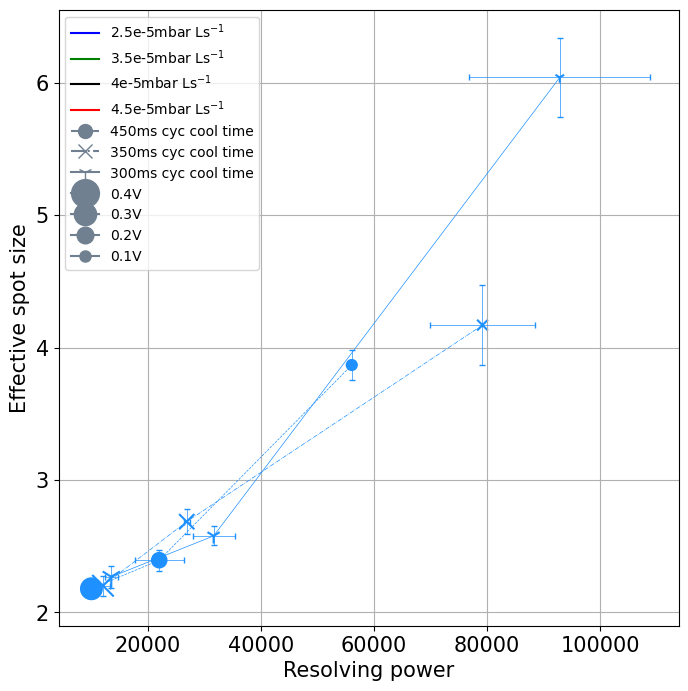

In [9]:
times = np.sort(measurements["cyc_cool_time"].unique())
gases = np.sort(measurements["gas_flow"].unique())
volts = np.sort(measurements["voltage"].unique())
fig2, ax2 = plt.subplots(1, 1, figsize = (8, 8))
for t in times:
    mtime = filter_dataframe(measurements, "cyc_cool_time", "==", t)
    dftime = filter_dataframe(df, "cyc_cooling_time", "==", t)
    for g in gases:
            mvolt = filter_dataframe(mtime, "gas_flow", "==", g)
            dfvolt = filter_dataframe(dftime, "gas_flow", "==", g)
            if mvolt.empty == True:
                continue
            if g == 1e-5:
                continue
#                 c = "red"
            if g == 2.5e-5:
#                 c = "blue"
                continue
            if g == 3.5e-5:
#                 c = "green"
                continue
            if g == 4e-5:
#                 c = "black"
                continue
            if g == 4.5e-5:
#                 continue
                c = "dodgerblue"
            if g == 1e-4:
                continue
#                 c = "magenta"
            if g == 1e-3:
                continue
                c = "orange"
            if g == 5e-4:
                continue
                c = "yellow"
            if t == 450:
                style = "--o"
                style1 = "o"
            if t == 350:
                style = "-.x"
                style1 = "x"
            if t == 300:
                style = "-1"
                style1 = "1"
#             if t != 450:
#                 continue
            if t == 250:
                continue
#                 style = "-^"
#             if volt >= 0.6:
#                 continue
#             if volt == 
#             if volt ==
#             if volt ==
#             print(volt)
#             print(mvolt)
            sizes = [float(mvolt["voltage"].unique()[i] * 600) for i in range(len(mvolt["voltage"].unique()))]
            print(sizes )
            plt.errorbar(x = mvolt["res_p"], y = dfvolt["eff_radius"], 
                         xerr = mvolt["res_p_err"], yerr = dfvolt["total_err"],
                         color = c, fmt = style, capsize = 2, linewidth = 0.5, markersize = 0.1)
            plt.scatter(x = mvolt["res_p"], y = dfvolt["eff_radius"],
                         color = c, marker = style1, s = sizes)
            
plt.grid()
plt.xlabel("Resolving power", fontsize = 15)
plt.ylabel("Effective spot size", fontsize = 15)
custom_lines = [
#                 Line2D([0], [0], color="red"),
                Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="green"), 
                Line2D([0], [0], color="black"),
                Line2D([0], [0], color="red"),
#                 Line2D([0], [0], color="magenta"),
#                 Line2D([0], [0], color="orange"), 
#                 Line2D([0], [0], color="yellow"), 

                Line2D([0], [0], marker='o', linestyle = "--", color = "slategray", markersize = 10),
                Line2D([0], [0], marker='x', linestyle = "-.", color = "slategray", markersize = 10), 
                Line2D([0], [0], marker='1', linestyle = "-", color = "slategray", markersize = 10),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 20),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 16),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 12),
                Line2D([0], [0], marker='o', color = "slategray", markersize = 8)]

ax2.legend(custom_lines, [
#                           "1e-5mbar Ls$^{-1}$",
                          "2.5e-5mbar Ls$^{-1}$",
                          "3.5e-5mbar Ls$^{-1}$", 
                          "4e-5mbar Ls$^{-1}$",
                          "4.5e-5mbar Ls$^{-1}$",
#                           "1e-4mbar Ls$^{-1}$",
#                           "1e-3mbar Ls$^{-1}$", 
#                           "5e-4mbar Ls$^{-1}$",
                          "450ms cyc cool time",
                          "350ms cyc cool time",
                          "300ms cyc cool time",
                           "0.4V", "0.3V", "0.2V", "0.1V"],
#                           "250ms cyc cool time"],
                        fontsize = 10)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# print(mvolt)
plt.show()    

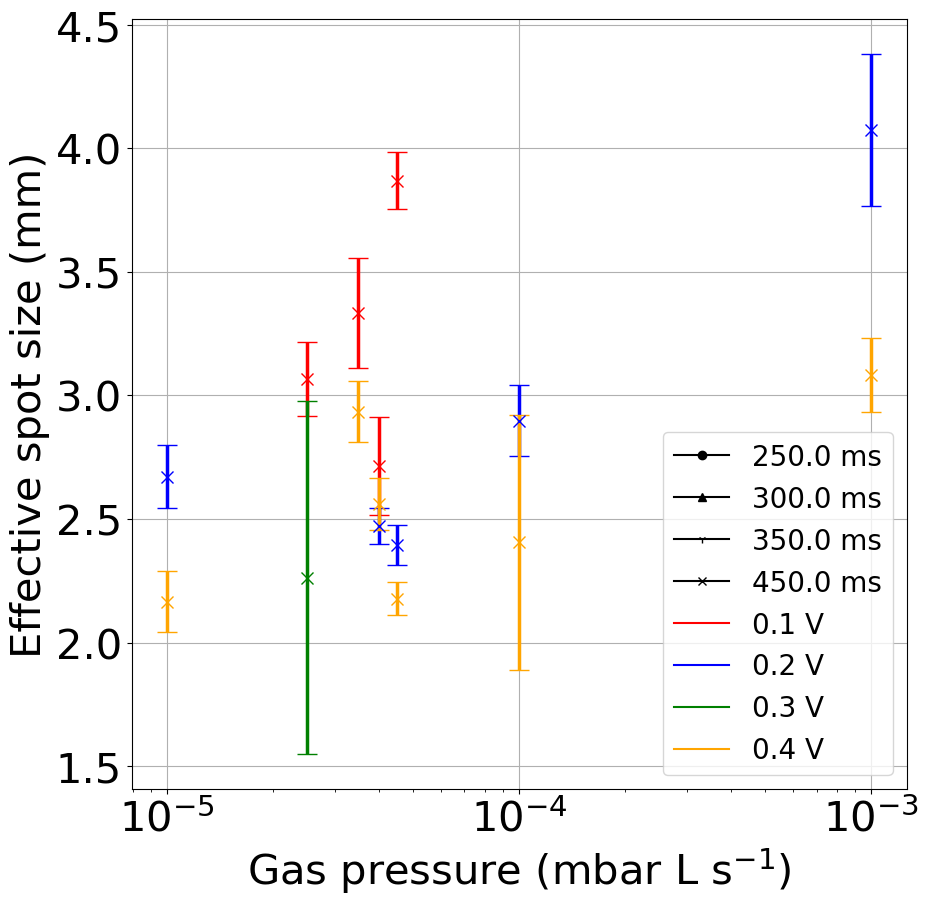

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for t in times:
    timefilter = filter_dataframe(measurements, "cyc_cool_time", "==", t)
    dftime = filter_dataframe(df, "cyc_cooling_time", "==", t)
    for g in gases:
        gasfilter = filter_dataframe(timefilter, "gas_flow", "==", g)
        dfgas = filter_dataframe(dftime, "gas_flow", "==", g)
        if gasfilter.empty == True:
            continue
        for volt in volts:
            voltfilter = filter_dataframe(gasfilter, "voltage", "==", volt)
            dfvolt = filter_dataframe(dfgas, "voltage_V", "==", volt)
            if voltfilter.empty == True:
                continue
            if volt >= 0.6:
                continue
            else:
                if t == times[0]:
                    continue
                    style = "o"
                if t == times[1]:
                    continue
                    style = "^"
                if t == times[2]:
                    continue
                    style = "1"
                if t == times[3]:
                    style = "x"
                if volt == volts[0]:
                    c = "red"
                if volt == volts[1]:
                    c = "blue"
                if volt == volts[2]:
                    c = "green"
                if volt == volts[3]:
                    c = "orange"
#                 if volt == volts[4]:
#                     c = "magenta"
#                 if volt == volts[5]:
#                     c = "orange"
                
                plt.errorbar(voltfilter["gas_flow"], dfvolt["eff_radius"], 
                             yerr = dfvolt["total_err"], fmt = style, color = c, markersize = 8, 
                            capsize = 7, linewidth = 2.5)
                
custom_lines = [Line2D([0], [0], marker='o', color = "black"),
                Line2D([0], [0], marker='^', color = "black"), 
                Line2D([0], [0], marker='1', color = "black"),
                Line2D([0], [0], marker='x', color = "black"),
                Line2D([0], [0], color="red"),
                Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="green"), 
                Line2D([0], [0], color="orange"),
                Line2D([0], [0], color="magenta"),
                Line2D([0], [0], color="orange")]

ax.legend(custom_lines, [f"{times[0]} ms", f"{times[1]} ms", f"{times[2]} ms", f"{times[3]} ms",
                         f"{volts[0]} V", f"{volts[1]} V", f"{volts[2]} V", f"{volts[3]} V"], fontsize = 20)
plt.grid()
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel("Gas pressure (mbar L s$^{-1}$)", fontsize = 30)
plt.ylabel("Effective spot size (mm)", fontsize = 30)
plt.xscale("log")
plt.show()

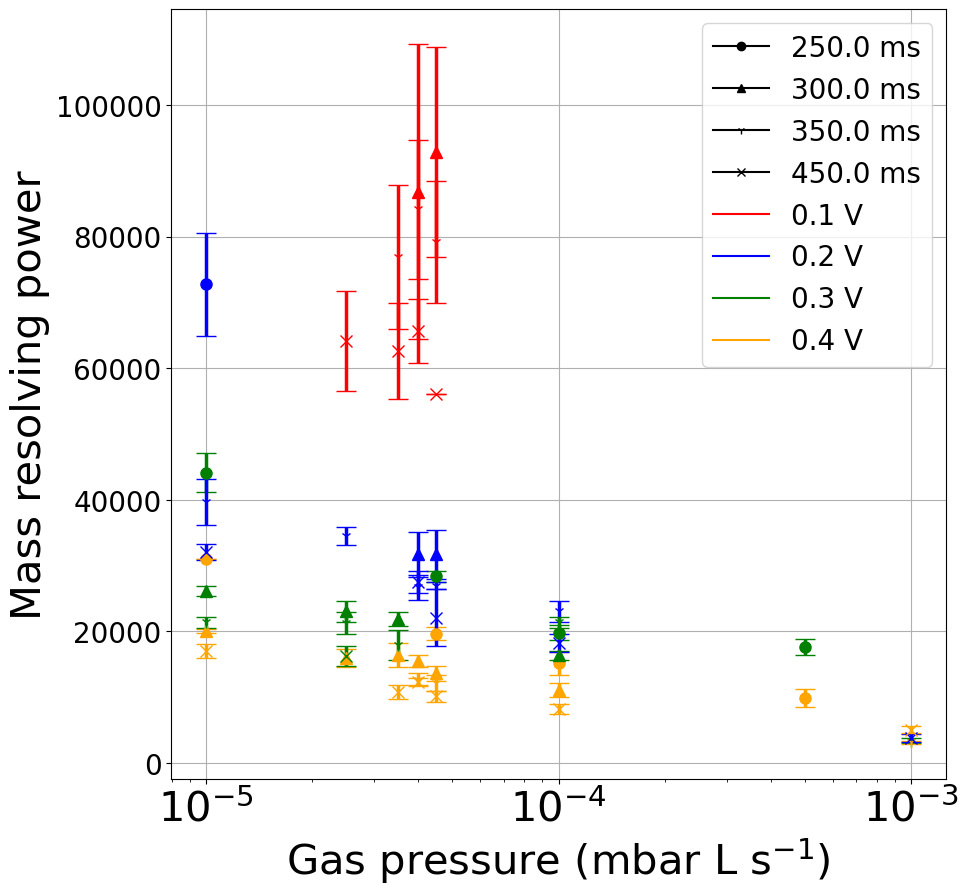

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for t in times:
    timefilter = filter_dataframe(measurements, "cyc_cool_time", "==", t)
    for g in gases:
        gasfilter = filter_dataframe(timefilter, "gas_flow", "==", g)
        if gasfilter.empty == True:
            continue
        for volt in volts:
            voltfilter = filter_dataframe(gasfilter, "voltage", "==", volt)
            if voltfilter.empty == True:
                continue
            if volt >= 0.6:
                continue
            else:
                if t == times[0]:
                    style = "o"
                if t == times[1]:
                    style = "^"
                if t == times[2]:
                    style = "1"
                if t == times[3]:
                    style = "x"
                if volt == volts[0]:
                    c = "red"
                if volt == volts[1]:
                    c = "blue"
                if volt == volts[2]:
                    c = "green"
                if volt == volts[3]:
                    c = "orange"
#                 if volt == volts[4]:
#                     c = "magenta"
#                 if volt == volts[5]:
#                     c = "orange"
                
                plt.errorbar(voltfilter["gas_flow"], voltfilter["res_p"], 
                             yerr = voltfilter["res_p_err"], fmt = style, color = c, markersize = 8, 
                            capsize = 7, linewidth = 2.5)
                
custom_lines = [Line2D([0], [0], marker='o', color = "black"),
                Line2D([0], [0], marker='^', color = "black"), 
                Line2D([0], [0], marker='1', color = "black"),
                Line2D([0], [0], marker='x', color = "black"),
                Line2D([0], [0], color="red"),
                Line2D([0], [0], color="blue"),
                Line2D([0], [0], color="green"), 
                Line2D([0], [0], color="orange"),
                Line2D([0], [0], color="magenta"),
                Line2D([0], [0], color="orange")]

ax.legend(custom_lines, [f"{times[0]} ms", f"{times[1]} ms", f"{times[2]} ms", f"{times[3]} ms",
                         f"{volts[0]} V", f"{volts[1]} V", f"{volts[2]} V", f"{volts[3]} V"], fontsize = 20)
plt.grid()
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 20)
plt.xlabel("Gas pressure (mbar L s$^{-1}$)", fontsize = 30)
plt.ylabel("Mass resolving power", fontsize = 30)
plt.xscale("log")
plt.show()

In [12]:
# function = cut_gauss
# inParams = [808570, 5, 5, 0.8]

# # colors = ['blue', 'red', 'yellow', 'green', 'darkorchid', "cyan", ""]
# x = np.linspace(808400, 808750, 1000)

# x_a, y_a, z_a = complete_df["frequency"], complete_df["voltage_V"], complete_df["count"] / max(complete_df["count"])

# voltageaxis = complete_df["voltage_V"].unique()
# timeaxis = complete_df["time_ms"].unique()

# ax = []
# for i in range(3):
#     ax.append(plt.figure(figsize = (7,7)).add_subplot(projection='3d'))
    
# for i in range(len(ax)):
#     for voltage in voltageaxis:
#         df_time = filter_dataframe(complete_df, "time_ms", "==", timeaxis[i])
#         df_V = filter_dataframe(df_time, "voltage_V", "==", voltage)
#         x, y, z = df_V["frequency"], np.ones(len(df_V["voltage_V"])) * voltage, df_V["count"] / max(df_V["count"])
#         ax[i].scatter(xs = x, ys = y, zs = z)
# #         rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
# #         surf = ax[i].plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
# #                        linewidth=0, antialiased=False, shade=False)    
# #     ax.scatter(xs = x, ys = y, zs = z)
# # ls = LightSource(270, 45)

# # ax.set_xlabel("X label")
# # ax.set_ylabel("Y label")
# # ax.set_zlabel("Z label")

# plt.show()

In [13]:
# vc = 808570
# vmin = 551
# vz = (vc * np.sqrt((1 - (1-(2 * vmin / vc))**2) / 2))
# print(f"nu_z = {vz}")
# print(f"T_z/8 = {1 / vz * 10 ** 6 /8 *7}us")
# print(f"vmin = {808570 / 2 * (1 - np.sqrt(1 - 2 * (vz / vc)**2))}")

In [14]:
print(((206977418.605 + 206975896.821) / 2 ) / (206977418.605 - 206975896.821))
#207 Po and 

136009.2218841759


In [15]:
print(((208985351.713 + 208981089.978) / 2 ) / (208985351.713 - 208981089.978))

49037.12240315236


In [16]:
print(((199990351.099 + 199995705.335) / 2 ) / (199995705.335 - 199990351.099))
# At and Rn

37352.299789726596


In [17]:
print(((199981812.355 + 199995705.335) / 2) / (199995705.335 - 199981812.355))




# # 207 Pb Tl
# 209 Pb Tl
# 200 At (-1 or -2 protons)
# 257/8 Db (-1 proton)

14394.95046021267
